In [1]:
import sys
sys.path.insert(0,'/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg')
sys.path.insert(0,'/exp/rhuang/meta/k2/k2/python')
sys.path.insert(0,'/exp/rhuang/meta/k2/temp.linux-x86_64-cpython-310/lib')
sys.path.insert(0,'/exp/rhuang/meta/icefall')

In [2]:
# librispeech (long audio + raw text) + factored transducer: 
# /scratch4/skhudan1/rhuang25/icefall/egs/librispeech/ASR/download/LibriSpeechOriginal
# https://github.com/kaldi-asr/kaldi/blob/master/egs/librispeech/s5/local/lm/python/text_pre_process.py

# https://medium.com/@yaduvanshiharsh15/speaker-recognition-using-deep-learning-890fe812a976
# https://dagshub.com/DagsHub/Librispeech-ASR-corpus/src/master/README.md
# https://github.com/alicank/Translation-Augmented-LibriSpeech-Corpus

In [ ]:
# ls /scratch4/skhudan1/rhuang25/icefall/egs/librispeech/ASR/download/LibriSpeechOriginal/LibriSpeech/mp3/2067/143535/
# 143535.mp3                   2067-143535.seg.txt          2067-143535.sents.seg.txt    2067-143535.sents.trans.txt  2067-143535.trans.txt        intro.seg.txt

# ffprobe -v error -show_entries format=duration -of default=noprint_wrappers=1:nokey=1 /scratch4/skhudan1/rhuang25/icefall/egs/librispeech/ASR/download/LibriSpeechOriginal/LibriSpeech/mp3/2067/143535/143535.mp3

# less /scratch4/skhudan1/rhuang25/icefall/egs/librispeech/ASR/download/LibriSpeechOriginal/LibriSpeech/CHAPTERS.TXT
# ;ID    |READER|MINUTES| SUBSET           | PROJ.|BOOK ID| CH. TITLE | PROJECT TITLE
# 143521 | 1913 | 9.55  | train-clean-360  | 1352 | 3155  | Introduction | She
# 143535 | 2067 | 16.01 | train-other-500  | 1352 | 3155  | A Soul in Hell | She
# 143536 | 2067 | 14.14 | train-other-500  | 1352 | 3155  | Ayesha Gives Judgement | She

# less /scratch4/skhudan1/rhuang25/icefall/egs/librispeech/ASR/download/LibriSpeechOriginal/LibriSpeech/books/ascii/3155/3155.txt

# scp rhuang25@login.rockfish.jhu.edu:/scratch4/skhudan1/rhuang25/icefall/egs/librispeech/ASR/download/LibriSpeechOriginal/LibriSpeech/books/ascii/3155/3155.txt /exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/scripts/temp/.
# scp rhuang25@login.rockfish.jhu.edu:/scratch4/skhudan1/rhuang25/icefall/egs/librispeech/ASR/download/LibriSpeechOriginal/LibriSpeech/mp3/2067/143535/143535.mp3 /exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/scripts/temp/.
# scp rhuang25@login.rockfish.jhu.edu:/scratch4/skhudan1/rhuang25/icefall/egs/librispeech/ASR/download/LibriSpeechOriginal/LibriSpeech/mp3/2067/143536/143535.mp3 /exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/scripts/temp/.
# scp rhuang25@login.rockfish.jhu.edu:/scratch4/skhudan1/rhuang25/icefall/egs/librispeech/ASR/download/LibriSpeechOriginal/LibriSpeech/mp3/1913/143521/143521.mp3 /exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/scripts/temp/.

In [2]:
# Reference: /exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/scripts/alignment.ipynb

%cd /exp/rhuang/meta/icefall/egs/librispeech/ASR
%pwd  #look at the current work dir

/exp/rhuang/meta/icefall/egs/librispeech/ASR


'/exp/rhuang/meta/icefall/egs/librispeech/ASR'

In [3]:
import argparse
import logging
from collections import defaultdict
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import k2
import sentencepiece as spm
import torch
import torch.nn as nn
from asr_datamodule import LibriSpeechAsrDataModule
from conformer import Conformer

from icefall.bpe_graph_compiler import BpeCtcTrainingGraphCompiler
from icefall.checkpoint import (
    average_checkpoints,
    average_checkpoints_with_averaged_model,
    find_checkpoints,
    load_checkpoint,
)
from icefall.decode import (
    get_lattice,
    nbest_decoding,
    nbest_oracle,
    one_best_decoding,
    rescore_with_attention_decoder,
    rescore_with_n_best_list,
    rescore_with_rnn_lm,
    rescore_with_whole_lattice,
)
from icefall.env import get_env_info
from icefall.lexicon import Lexicon
from icefall.rnn_lm.model import RnnLmModel
from icefall.utils import (
    AttributeDict,
    get_texts,
    load_averaged_model,
    setup_logger,
    store_transcripts,
    str2bool,
    write_error_stats,
)
# from train import get_params as get_train_params
from decode_small import get_parser, get_params
from icefall.decode import get_lattice, one_best_decoding
from icefall.utils import get_alignments, get_texts, get_texts_with_timestamp

import psutil
try:
    from tqdm_loggable.auto import tqdm
except:
    from tqdm import tqdm
import torch.multiprocessing as mp

import torchaudio

from IPython.display import Audio
from data_transforms import LhotseFbank

fbank_transform = LhotseFbank()

from factor_transducer import *
import string

/home/hltcoe/rhuang/mambaforge/envs/aligner5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
parser = get_parser()
LibriSpeechAsrDataModule.add_arguments(parser)
args = parser.parse_args(args=[])

args.exp_dir = "/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/exp/exp_seed_small_model/"
args.epoch = 30
args.avg = 8
args.use_averaged_model = True

args.manifest_dir = "/exp/rhuang/meta/icefall/egs/librispeech/ASR/data/fbank/"
args.max_duration = 30
args.world_size = 1
args.method = 'ctc-decoding'

args.exp_dir = Path(args.exp_dir)
args.lang_dir = Path(args.lang_dir)
args.lm_dir = Path(args.lm_dir)
args.manifest_dir = Path(args.manifest_dir)

params = get_params()
params.update(vars(args))

device = torch.device("cpu")

sp = spm.SentencePieceProcessor()
sp.load(params.bpe_model)

# <blk> is defined in local/train_bpe_model.py
params.blank_id = sp.piece_to_id("<blk>")
params.vocab_size = sp.get_piece_size()

In [5]:
print(params)

{'feature_dim': 80, 'subsampling_factor': 4, 'encoder_dim': 128, 'nhead': 8, 'dim_feedforward': 512, 'num_encoder_layers': 8, 'search_beam': 20, 'output_beam': 8, 'min_active_states': 30, 'max_active_states': 10000, 'use_double_scores': True, 'env_info': {'k2-version': '1.24.3', 'k2-build-type': 'Debug', 'k2-with-cuda': True, 'k2-git-sha1': '2b2ac14b326d61d79d04e53fbd69b1ff6d630411', 'k2-git-date': 'Wed Aug 23 17:58:26 2023', 'lhotse-version': '1.20.0.dev+git.c863fa72.clean', 'torch-version': '2.0.1', 'torch-cuda-available': False, 'torch-cuda-version': '11.7', 'python-version': '3.1', 'icefall-git-branch': 'context', 'icefall-git-sha1': '8c85f6a-dirty', 'icefall-git-date': 'Sat Feb 17 13:19:09 2024', 'icefall-path': '/exp/rhuang/meta/icefall', 'k2-path': '/exp/rhuang/meta/k2/k2/python/k2/__init__.py', 'lhotse-path': '/exp/rhuang/meta/lhotse/lhotse/__init__.py', 'hostname': 'test2', 'IP address': '10.1.250.202'}, 'blank_id': 0, 'vocab_size': 500, 'my_args': None, 'epoch': 30, 'iter': 0

In [6]:
logging.info("About to create model")
model = Conformer(
    num_features=params.feature_dim,
    nhead=params.nhead,
    d_model=params.encoder_dim,
    num_classes=params.vocab_size,
    subsampling_factor=params.subsampling_factor,
    num_encoder_layers=params.num_encoder_layers,
    num_decoder_layers=params.num_decoder_layers,
)

load_checkpoint(f"{params.exp_dir}/epoch-{params.epoch}.pt", model)
model.to(device)

num_param = sum([p.numel() for p in model.parameters()])
logging.info(f"Number of model parameters: {num_param}")

In [7]:
_ = model.eval()
# _ = model.train()

In [8]:
args.return_cuts = True
librispeech = LibriSpeechAsrDataModule(args)

train_cuts = librispeech.train_clean_100_cuts()
# if params.full_libri:
#     train_cuts += librispeech.train_clean_360_cuts()
#     train_cuts += librispeech.train_other_500_cuts()
# train_cuts = librispeech.train_other_500_cuts()
train_cuts = train_cuts.to_eager()

# valid_cuts = librispeech.dev_clean_cuts()
# valid_cuts += librispeech.dev_other_cuts()

# test_cuts = librispeech.test_clean_cuts()
# test_cuts += librispeech.test_other_cuts()
# test_cuts = test_cuts.to_eager()

In [8]:
wav_file = "/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/scripts/temp/143535.mp3"
waveform, sample_rate = torchaudio.load(wav_file)
if waveform.size(0) > 1:
    # waveform = waveform[:1]
    waveform = torch.mean(waveform, axis=0)
waveform = waveform.squeeze(0)
print(f"waveform: {waveform.shape}, sample_rate: {sample_rate}")
print(f"duratioin: {waveform.shape[0]/sample_rate:.2f} secs")

waveform: torch.Size([51998976]), sample_rate: 44100
duratioin: 1179.12 secs


In [9]:
# start = 0
# end = int(len(waveform)*0.05)

# start = 1499948 
# end = 2599948

start = 2199948 
end = 2599948

my_waveform = waveform[start: end]

Audio(my_waveform.numpy(), rate=sample_rate)

In [10]:
feature = fbank_transform(my_waveform, sampling_rate=sample_rate)
feature = feature.unsqueeze(0)
feature.shape

torch.Size([1, 907, 80])

In [11]:
def normalize(text: str) -> str:
    # Remove all punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Convert all upper case to lower case
    text = text.upper()
    return text

def load_book(filename):
    with open(filename, 'r') as fin:
        lines = [normalize(l.strip()) for l in fin]
    
    lines = [l for l in lines if len(l) > 0]
    book = " ".join(lines)
    return book

book = load_book("/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/scripts/temp/3155.txt")

# book = book.split()[30000: 69585]
# book = " ".join(book)

print(f"book: {book[:100]}")
print(f"len(book) chars: {len(book)}, len(book) words: {len(book.split())}")

book: THE PROJECT GUTENBERG EBOOK OF SHE BY H RIDER HAGGARD THIS EBOOK IS FOR THE USE OF ANYONE ANYWHERE A
len(book) chars: 711863, len(book) words: 129276


In [12]:
long_text_results = [None]
long_text_results = convert_long_text_to_fst({"book": book}.items(), sp, 0, long_text_results)

libri_long_text [0]: 100%|██████████| 1/1 [00:16<00:00, 16.36s/it]


### Debug

In [44]:
text = book
word_id_list = sp.encode(text, out_type=int)
word_start_symbols = {i for i in range(sp.vocab_size()) if sp.id_to_piece(i).startswith('▁')}
return_str=True, 
blank_penalty=0
skip_penalty=-0.5

fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

c_str = k2.to_str_simple(fst_graph)
arcs = c_str.strip().split("\n")
arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
final_state = int(arcs[-1])

arcs = arcs[:-1]
arcs = [tuple(map(int, a.split())) for a in arcs]
# ss, ee, l1, l2, w = arc

counter = WordCounter()
counter.f3()

non_eps_nodes1 = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0 and arc[3] in word_start_symbols)   # if this node has a non-eps, word-start in-coming arc
non_eps_nodes1 = sorted(non_eps_nodes1, key=lambda x: x[0])
self_loops = {ss: l1 for ss, ee, l1, l2, w in arcs if ss == ee}
non_eps_nodes2 = list((arc[0], arc[1]) if self_loops[arc[0]] > 0 else (arc[0] - 1, arc[1]) for arc in arcs if arc[3] < 0 or (arc[3] > 0 and arc[3] in word_start_symbols and arc[0] > 0))   # if this node has a non-eps, word-start out-going arc; be careful for the special case
non_eps_nodes2 = [non_eps_nodes2[0]] + [(ss2, ee2) for (ss1, ee1), (ss2, ee2) in zip(non_eps_nodes2, non_eps_nodes2[1:]) if ss2 != ss1]  # deduplication

# eps_arcs1 = [(ss, ee) for ss, ee, l1, l2, w in arcs if ss != ee and l1 == 0]
# token_starts = [ss for ss, ee, l1, l2, w in arcs if ss == ee and l1 > 0]
eps_self_loops = [ss for ss, l1 in self_loops.items() if l1 == 0]
eps_self_loops = sorted(eps_self_loops[1:-1])

arcs = [arcs[0]] + arcs[2:-5] + [a for a in arcs[-5:] if a[2] >= 0]
arcs = [[ss, ee, l1, 0, w] for ss, ee, l1, l2, w in arcs]

# in-coming arcs
arcs += [(0, n, l, counter.f1(), 0) for n, l in non_eps_nodes1]

# out-going arcs
arcs += [(n, final_state, self_loops[n], counter.f3(), 0) for n, l in non_eps_nodes2 if self_loops[n] > 0]
arcs += [(final_state - 1, final_state, self_loops[final_state - 1], counter.counter3, 0)]

# skip arcs
# arcs += [(n, next_token, self_loops[next_token], 0, 0) for ns, next_token in zip(eps_arcs1, token_starts[2:]) for n in ns]
arcs += [(n1, n2, 0, 0, skip_penalty) for n1, n2 in zip(eps_self_loops, eps_self_loops[1:])]

In [45]:
node_arcs_in = defaultdict(list)
node_arcs_out = defaultdict(list)
for a in arcs:
    ss, ee, l1, l2, w = a
    node_arcs_out[ss].append(a)
    node_arcs_in[ee].append(a)

In [50]:
cur_edge_id = -1
for i in range(1, final_state):
    for in_arc in node_arcs_in[i]:
        if in_arc[0] == 0 and in_arc[3] > 0:
            assert in_arc[3] >= cur_edge_id, f"in_arc={in_arc}, cur_edge_id={cur_edge_id}"
            cur_edge_id = in_arc[3]
    for out_arc in node_arcs_out[i]:
        if out_arc[1] == final_state and out_arc[3] > 0:
            assert out_arc[3] >= cur_edge_id, f"out_arc={out_arc}, cur_edge_id={cur_edge_id}"
            cur_edge_id = out_arc[3]

In [38]:
node_arcs_in[19036]

[[19035, 19036, 0, 0, 0], [19036, 19036, 0, 0, 0], (19034, 19036, 0, 0, -0.5)]

In [39]:
node_arcs_out[19036]

[[19036, 19036, 0, 0, 0], [19036, 19037, 47, 0, 0], (19036, 19038, 0, 0, -0.5)]

In [52]:
word_start = {w[0]: i+1 for i, w in enumerate(non_eps_nodes1)}
word_end = [w - j for w, i in word_start.items() for j in [1, 2] if w - j > 0]
word_end = [w for w in word_end if self_loops[w] > 0]
# print(sorted(word_start)[:100])
# print(sorted(word_end)[:100])

node_arcs_in = defaultdict(list)
node_arcs_out = defaultdict(list)
for a in arcs:
    ss, ee, l1, l2, w = a
    node_arcs_out[ss].append(a)
    node_arcs_in[ee].append(a)
for i in word_end:
    out_arc_label = None
    next_word_label = None
    for out_arc in node_arcs_out[i]:
        if out_arc[1] == final_state:
            out_arc_label = out_arc[3]
        if out_arc[1] in word_start and out_arc[0] != out_arc[1]:
            next_word_label = word_start[out_arc[1]]
    if next_word_label is None:
        next_word_label = word_start.get(i + 2, None)
    if self_loops[i] > 0:
        assert out_arc_label == next_word_label, f"state={i}, out_arc_label={out_arc_label}, next_word_label={next_word_label}"

In [64]:
assert len(word_start) == len(word_end) + 1
assert len(word_start) == len(book.split())
assert len(word_start) == len(non_eps_nodes2)
print(sorted(word_start)[:100])
print(sorted(word_end)[:100])

[1, 3, 13, 25, 31, 33, 35, 37, 41, 47, 53, 55, 61, 63, 65, 67, 71, 73, 79, 87, 89, 91, 95, 97, 99, 101, 103, 115, 125, 127, 129, 135, 137, 139, 141, 143, 145, 151, 153, 155, 157, 165, 167, 169, 179, 191, 199, 211, 213, 215, 221, 223, 229, 231, 253, 259, 261, 269, 273, 279, 285, 293, 297, 305, 309, 313, 319, 323, 325, 329, 331, 337, 339, 343, 347, 351, 359, 367, 375, 379, 389, 395, 401, 403, 405, 415, 427, 433, 435, 445, 447, 453, 461, 469, 475, 491, 497, 505, 507, 509]
[1, 11, 23, 29, 31, 33, 35, 39, 45, 51, 53, 59, 61, 63, 65, 69, 71, 77, 85, 87, 89, 93, 95, 97, 99, 101, 113, 123, 125, 127, 133, 135, 137, 139, 141, 143, 149, 151, 153, 155, 163, 165, 167, 177, 189, 197, 209, 211, 213, 219, 221, 227, 229, 251, 257, 259, 267, 271, 277, 283, 291, 295, 303, 307, 311, 317, 321, 323, 327, 329, 335, 337, 341, 345, 349, 357, 365, 373, 377, 387, 393, 399, 401, 403, 413, 425, 431, 433, 443, 445, 451, 459, 467, 473, 489, 495, 503, 505, 507, 511]


In [60]:
len(word_start)

129276

In [62]:
sorted(list((arc[0], arc[1]) for arc in arcs if arc[3] < 0 or (arc[3] > 0 and arc[3] in word_start_symbols and arc[0] > 0)))[-10:]

[(2095, 541807),
 (2097, 541807),
 (2099, 541807),
 (2101, 541807),
 (2103, 541807),
 (2111, 541807),
 (2113, 541807),
 (2115, 541807),
 (2117, 541807),
 (2121, 541807)]

In [57]:
print(sorted(word_end)[-10:])

[541751, 541765, 541767, 541769, 541777, 541787, 541789, 541793, 541795, 541797]


In [47]:
node_arcs_out[18983]

[[18983, 18984, 0, 0, 0],
 [18983, 18983, 168, 0, 0],
 (18983, 541807, 168, 5018, 0)]

In [32]:
[sp.id_to_piece(x) for x in [word_id_list]]

['▁PRO']

In [27]:
non_eps_nodes1

[(1, 4),
 (3, 149),
 (13, 80),
 (25, 54),
 (31, 9),
 (33, 73),
 (35, 104),
 (37, 34),
 (41, 307),
 (47, 132),
 (53, 107),
 (55, 54),
 (61, 67),
 (63, 42),
 (65, 4),
 (67, 212),
 (71, 9),
 (73, 253),
 (79, 253),
 (87, 84),
 (89, 94),
 (91, 220),
 (95, 7),
 (97, 55),
 (99, 488),
 (101, 94),
 (103, 49),
 (115, 156),
 (125, 47),
 (127, 331),
 (129, 220),
 (135, 30),
 (137, 358),
 (139, 30),
 (141, 369),
 (143, 120),
 (145, 49),
 (151, 30),
 (153, 367),
 (155, 4),
 (157, 56),
 (165, 9),
 (167, 4),
 (169, 149),
 (179, 80),
 (191, 166),
 (199, 15),
 (211, 55),
 (213, 107),
 (215, 54),
 (221, 120),
 (223, 74),
 (229, 84),
 (231, 122),
 (253, 56),
 (259, 73),
 (261, 5),
 (269, 34),
 (273, 307),
 (279, 132),
 (285, 49),
 (293, 121),
 (297, 5),
 (305, 34),
 (309, 34),
 (313, 54),
 (319, 34),
 (323, 107),
 (325, 147),
 (329, 391),
 (331, 176),
 (337, 74),
 (339, 420),
 (343, 34),
 (347, 34),
 (351, 129),
 (359, 54),
 (367, 243),
 (375, 125),
 (379, 214),
 (389, 57),
 (395, 109),
 (401, 9),
 (403, 

### Done debug

In [13]:
my_fst = k2.Fsa.from_str(long_text_results["book"], acceptor=False)
num_states = my_fst.shape[0]
num_arcs = my_fst.num_arcs
print(f"num_states: {num_states}, num_arcs: {num_arcs}")

num_states: 541809, num_arcs: 2012036


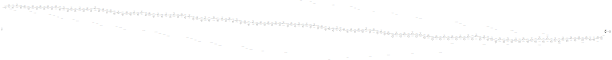

In [93]:
# k2.to_dot(my_fst)

In [14]:
feature = feature
batch = {
    "supervisions": {
        "text": "",
        "cut": None,
        "sequence_idx": torch.arange(1),
        "start_frame": torch.zeros(1),
        "num_frames": torch.Tensor([feature.size(1)]).int(),
    },
    "inputs": feature,
}
supervisions = batch["supervisions"]

In [15]:
ctc_output, memory, memory_key_padding_mask = model(feature, supervisions)  # ctc_output is (N, T, C)
encoder_out_lens = torch.div(
    supervisions["num_frames"],
    params.subsampling_factor,
    rounding_mode="floor",
) - 1  # to fix some issues -- just discard some frames
print(f"encoder_out_lens: {encoder_out_lens}")
print(f"ctc_output.shape: {ctc_output.shape}")

encoder_out_lens: tensor([225], dtype=torch.int32)
ctc_output.shape: torch.Size([1, 226, 500])


In [16]:
input_lengths = encoder_out_lens
batch_size = input_lengths.size(0)
# TODO
supervision_segments = torch.stack(
    (
        torch.arange(batch_size),
        torch.zeros(batch_size),
        input_lengths.cpu(),
    ),
    1,
).to(torch.int32)
indices = torch.argsort(supervision_segments[:, 2], descending=True)
supervision_segments = supervision_segments[indices]

In [17]:
def greedy(ctc_output):
    # Find the difference between consecutive elements
    diff = torch.diff(ctc_output)

    # Append a non-zero value to the start of the difference tensor
    diff = torch.cat((torch.tensor([1]), diff))

    # Find the indices of the non-zero elements
    indices = torch.nonzero(diff).squeeze()

    # Get the unique consecutive values
    unique = ctc_output[indices]

    # Remove all 0's
    result = unique[unique != 0]
    return result

In [18]:
print(book[:1000])
print(sp.encode(book[:1000], out_type=int))
print(ctc_output.argmax(dim=-1))
print(sp.decode(greedy(ctc_output.argmax(dim=-1).squeeze()).tolist()))

THE PROJECT GUTENBERG EBOOK OF SHE BY H RIDER HAGGARD THIS EBOOK IS FOR THE USE OF ANYONE ANYWHERE AT NO COST AND WITH ALMOST NO RESTRICTIONS WHATSOEVER  YOU MAY COPY IT GIVE IT AWAY OR REUSE IT UNDER THE TERMS OF THE PROJECT GUTENBERG LICENSE INCLUDED WITH THIS EBOOK OR ONLINE AT WWWGUTENBERGORG TITLE SHE AUTHOR H RIDER HAGGARD RELEASE DATE APRIL 4 2006 EBOOK 3155 THIS FILE LAST UPDATED ON JULY 30 2010 LANGUAGE ENGLISH CHARACTER SET ENCODING ASCII  START OF THIS PROJECT GUTENBERG EBOOK SHE  PRODUCED BY JOHN BICKERS DAGNY WILLIAM KYNGESBURYE DAVID WIDGER SHE BY H RIDER HAGGARD FIRST PUBLISHED 1886 IN EARTH AND SKIE AND SEA STRANGE THYNGS THER BE DOGGEREL COUPLET FROM THE SHERD OF AMENARTAS I INSCRIBE THIS HISTORY TO ANDREW LANG IN TOKEN OF PERSONAL REGARD AND OF MY SINCERE ADMIRATION FOR HIS LEARNING AND HIS WORKS ORIGINAL PREPARERS NOTE THIS TEXT WAS PREPARED FROM AN 1888 EDITION PUBLISHED BY LONGMANS GREEN AND CO LONDON A NUMBER OF FRAGMENTS OF GREEK TEXT AND SKETCHES HAVE BEEN OMITT

In [19]:
y_list = [my_fst]
decoding_graph = k2.create_fsa_vec(y_list)
decoding_graph = k2.arc_sort(decoding_graph)
decoding_graph.shape[0], decoding_graph.num_arcs

(1, 2012036)

In [20]:
log_probs = ctc_output
lattice = get_lattice(
    nnet_output=log_probs,
    decoding_graph=decoding_graph,
    supervision_segments=supervision_segments,
    search_beam=params.search_beam,
    output_beam=params.output_beam,
    min_active_states=params.min_active_states,
    max_active_states=params.max_active_states,
    subsampling_factor=params.subsampling_factor,
)
lattice = k2.connect(lattice)
lattice.shape[0], lattice.num_arcs

(1, 649)

In [21]:
best_path = one_best_decoding(
    lattice=lattice,
    use_double_scores=True,
)
best_path.shape[0], best_path.num_arcs

(1, 226)

In [22]:
hyps = get_texts(best_path)
print(f"hyps={hyps}")

hyps=[[69370, 69371, 69372, 69373, 69374, 69375, 69376, 69377, 69378, 69380, 69381, 69382, 69383, 69384, 69385, 69386, 69387, 69388, 69389, 69390, 69391, 69394, 69395, 69396, 69397, 69398, 69399]]


In [23]:
def get_str_by_range(book, rg):
    tlong = book.split()
    text = " ".join(tlong[rg[0] - 1: rg[-1] - 1])  # Note: we need to shift the index by one
    return text

In [24]:
hyps = get_texts(best_path)
print(f"hyps={hyps}")
print(f"[hyp]: {get_str_by_range(book, hyps[0])}")

hyps=[[69370, 69371, 69372, 69373, 69374, 69375, 69376, 69377, 69378, 69380, 69381, 69382, 69383, 69384, 69385, 69386, 69387, 69388, 69389, 69390, 69391, 69394, 69395, 69396, 69397, 69398, 69399]]
[hyp]: IT POSSIBLE THAT I A RATIONAL MAN NOT UNACQUAINTED WITH THE LEADING SCIENTIFIC FACTS OF OUR HISTORY AND HITHERTO AN ABSOLUTE AND UTTER DISBELIEVER IN ALL THE HOCUSPOCUS WHICH


In [55]:
word_list = book.split()
word_list.index("XIV")

69300

In [56]:
word_list[69300: 69310]

['XIV', 'A', 'SOUL', 'IN', 'HELL', 'IT', 'WAS', 'NEARLY', 'TEN', 'OCLOCK']